<a href="https://colab.research.google.com/github/sudheer-muthyala/Transformers_HuggingFace_Tensorflow/blob/main/transformers_intent_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from datasets import load_dataset
from transformers import DebertaTokenizerFast, DataCollatorWithPadding, TFDebertaForSequenceClassification, create_optimizer

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bitext/training-dataset-for-chatbotsvirtual-assistants
!unzip "/content/training-dataset-for-chatbotsvirtual-assistants.zip" -d "/content/dataset/"

In [ ]:
dataset=load_dataset("csv",
                      data_files="/content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")

In [ ]:
dataset["train"][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 'create_account'}

In [ ]:
intent_list = list(set(dataset["train"]["intent"]))
intent_dict = {intent_list[i]:i for i in range(len(intent_list))}
print(intent_dict)
print(len(intent_list))

{'cancel_order': 0, 'recover_password': 1, 'check_cancellation_fee': 2, 'check_invoices': 3, 'track_refund': 4, 'switch_account': 5, 'place_order': 6, 'registration_problems': 7, 'set_up_shipping_address': 8, 'create_account': 9, 'check_payment_methods': 10, 'delete_account': 11, 'check_refund_policy': 12, 'get_refund': 13, 'change_shipping_address': 14, 'get_invoice': 15, 'delivery_options': 16, 'change_order': 17, 'contact_customer_service': 18, 'track_order': 19, 'contact_human_agent': 20, 'review': 21, 'delivery_period': 22, 'complaint': 23, 'payment_issue': 24, 'edit_account': 25, 'newsletter_subscription': 26}
27


In [ ]:
def preprocess_dataset(example):
    return {'utterance':example['utterance'],
            'intent' : intent_dict[example['intent']]}

preprocess_dataset = dataset.map(preprocess_dataset)

In [ ]:
preprocess_dataset["train"][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 9}

In [ ]:
model_id="microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id)

In [ ]:
def tokenize_example(example):
    return tokenizer(example["utterance"], padding=True, truncation=True)

tokenize_dataset = preprocess_dataset.map(tokenize_example, batched=True)

In [ ]:
tokenize_dataset["train"]

Dataset({
    features: ['flags', 'utterance', 'category', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 21534
})

In [ ]:
BATCH_SIZE = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_dataset = tokenize_dataset["train"].to_tf_dataset(columns=['input_ids', 'token_type_ids', 'attention_mask'],
                                                     label_cols=['intent'],
                                                     shuffle=True,
                                                     collate_fn=data_collator,
                                                     batch_size=BATCH_SIZE)

In [ ]:
val_size = len(tokenize_dataset["train"]) // 10
test_size = int(val_size / 2)

val_dataset = tf_dataset.take(val_size)
train_dataset = tf_dataset.skip(val_size)
test_dataset = val_dataset.take(test_size)
val_dataset = val_dataset.skip(test_size)

In [ ]:
for element in test_dataset.take(1):
    print(element)

({'input_ids': <tf.Tensor: shape=(8, 33), dtype=int64, numpy=
array([[    1,   100,    33,    41,   696,    77,   667,     7,   582,
           13,   127,   645,     6,    64,    38,   266,    24,   116,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1,  7424,    47,   465,   335,    59,     5,  7107,     9,
            5, 19458,  1841,   116,     2,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1, 26316,   162,   114,    38,    64,  5124,    80,  2349,
           19,     5,   276,  1047,  1100,     2,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1,  6968,  2025,    75,  1903,     6,    99,   109,    38,
           33,     7,   109,     7,  1994,    19,    10,  1050,  2936,
    

In [ ]:
model = TFDebertaForSequenceClassification.from_pretrained(model_id, num_labels=len(intent_list))
model.summary()

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['cls_dropout', 'pooler', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_deberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLaye  multiple                  138601728 
 r)                                                              
                                                                 
 pooler (TFDebertaContextPo  multiple                  590592    
 oler)                                                           
                                                                 
 cls_dropout (TFDebertaStab  multiple                  0         
 leDropout)                                                      
                                                                 
 classifier (Dense)          multiple                  20763     
                                                                 
Total params: 139213083 (531.06 MB)
Trainable params: 139213083 (531.06 MB)
Non-trainable para

In [ ]:
num_epochs = 2
batches_per_epoch = len(tokenize_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model.compile(optimizer=optimizer, metrics=["accuracy"])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=num_epochs)

Epoch 1/2
539/539 [==============================] - 3495s 6s/step - loss: 0.1301 - accuracy: 0.9805 - val_loss: 0.0230 - val_accuracy: 0.9966
Epoch 2/2
539/539 [==============================] - 3361s 6s/step - loss: 0.0369 - accuracy: 0.9942 - val_loss: 0.0141 - val_accuracy: 0.9978


In [ ]:
predictions = []
labels_ = []

for input, label in test_dataset.take(2):
  pred = model.predict(input)
  predictions.append(tf.argmax(pred.logits, axis=-1).numpy())
  labels_.append(label.numpy())

1/1 [==============================] - 1s 1s/step


In [ ]:
print(predictions)
print(labels_)

[array([22, 24, 24, 24, 23, 17, 11, 15]), array([23, 14, 15, 18,  2, 24, 24,  7])]
[array([22, 24, 24, 24, 23, 17, 11, 15]), array([23, 14, 15, 18,  2, 24, 24,  7])]


In [ ]:
pred=np.concatenate([np.array(labels_[:-1]).flatten(),np.array(labels_[-1]).flatten()])
lab=np.concatenate([np.array(predictions[:-1]).flatten(),np.array(predictions[-1]).flatten()])

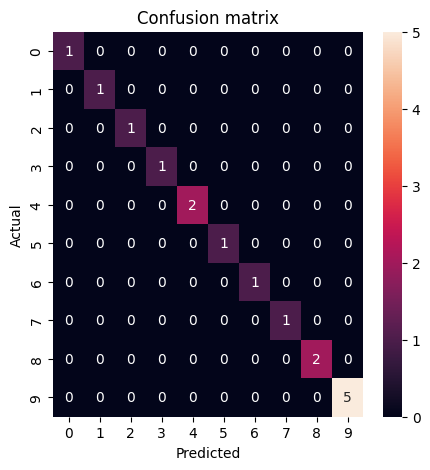

In [ ]:
cm = confusion_matrix(lab, pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()